In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [15]:
start_day_to_analyze = '2020-04-27'
end_day_to_analyze = '2020-04-28'

In [16]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [17]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [18]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [19]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [20]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2643,427,AVDL,buy,162,13.27,"{'avg': 12.9469, 'rsi': 71.64668827777966, 'ma...",2020-04-27 14:29:43.256866+00:00,2020-04-27 14:29:43.359819,12.69,15.05
1,2649,427,AVDL,sell,162,12.63,"{'avg': 12.9665, 'rsi': [50.64123588273728, 39...",2020-04-27 14:37:38.433984+00:00,2020-04-27 14:37:38.668726,12.69,15.05
2,2637,427,FRO,buy,434,11.41,"{'avg': 11.2755, 'rsi': 69.29445731620511, 'ma...",2020-04-27 14:13:42.099109+00:00,2020-04-27 14:13:42.387103,11.21,12.09
3,2660,427,FRO,sell,217,11.64,"{'avg': 11.3461, 'rsi': [62.15909080355979, 65...",2020-04-27 15:01:39.543257+00:00,2020-04-27 15:01:40.024222,11.21,12.09
4,2667,427,FRO,sell,217,11.87,"{'avg': 11.4164, 'rsi': [56.60323527421829, 65...",2020-04-27 15:29:04.130401+00:00,2020-04-27 15:29:04.313342,11.21,12.09
5,2639,427,HTZ,buy,956,4.09,"{'avg': 3.9949, 'rsi': 62.962972295227914, 'ma...",2020-04-27 14:20:52.264884+00:00,2020-04-27 14:20:52.356196,3.99,4.39
6,2645,427,HTZ,sell,956,4.18,"{'avg': 4.0103, 'rsi': [66.09341095129575, 70....",2020-04-27 14:32:48.253924+00:00,2020-04-27 14:32:48.954012,3.99,4.39
7,2647,427,HTZ,buy,503,4.18,"{'avg': 4.0134, 'rsi': 70.97302861138618, 'mac...",2020-04-27 14:33:59.931224+00:00,2020-04-27 14:34:00.078527,3.99,4.75
8,2656,427,HTZ,sell,15,4.28,"{'avg': 4.0357, 'rsi': [67.82447212110813, 70....",2020-04-27 14:49:17.556645+00:00,2020-04-27 14:49:17.754405,3.99,4.75
9,2657,427,HTZ,sell,236,4.28,"{'avg': 4.0357, 'rsi': [67.82447212110813, 70....",2020-04-27 14:49:17.628461+00:00,2020-04-27 14:49:17.801210,3.99,4.75


In [21]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [22]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [23]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,427,momentum_long,PAPER,v0.1-346-gcfe1018,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-27 13:45:01.641301,2020-04-27 20:10:01.176608,market close


,symbol,count,revenue
11,AVDL,2,-103.68
4,REAL,3,-44.28
0,IFRX,9,-8.55
9,JMIA,2,-4.55
5,MGM,3,-1.95
10,PENN,2,13.80
8,VXRT,3,23.52
3,YTEN,4,26.75
2,TNP,5,101.98
6,RESN,3,103.81


TOTAL REVENUE: 361.6 $


In [24]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df
            minute_history1[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=20)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')-timedelta(days=11)).date()).df

In [ ]:
minute_history['GLOP']

In [ ]:
minute_history1['GLOP']

In [ ]:
m = minute_history1['GLOP'].append(minute_history['GLOP'])

In [ ]:
m[:3976]

In [ ]:
RSI(m[:3976]['close'].dropna().between_time("9:30", "16:00"))

In [25]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(f"now={now}")
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

now=2020-04-27 10:03:13.025902
now=2020-04-27 10:03:13.117890
now=2020-04-27 10:03:18.540452
now=2020-04-27 10:41:56.789798
now=2020-04-27 10:41:59.932366
IFRX analysis for run 427 with profit -8.55


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-107.44,-107.44,buy,2020-04-27 14:03:13.025902,6.32,"[6.0, 6.04, 6.065, 6.18]",[6.4],17,"{'avg': 6.1841, 'rsi': 77.80776049699797, 'macd': [0.04928336613464257, 0.0495789260692856, 0.050043208911877635, 0.054224134684143444, 0.05847729151786574], 'vwap': 6.3219, 'supports': [6.0, 6.0, 6.04, 6.065, 6.07, 6.1, 6.1, 6.1001, 6.15, 6.1501, 6.18, 6.2, 6.25], 'sell_macd': [0.027046840227697544, 0.027322848245786346, 0.027702557763182867, 0.030495804688905004, 0.033315272362339776], 'slow macd': [0.06848226943417313, 0.0686900655366598, 0.06893132046255879, 0.06992268483786646, 0.07104281226218934], 'macd_signal': [0.050108080987900934, 0.050002250004177864, 0.05001044178571782, 0.05085318036540294, 0.0523780025958955], 'resistances': [6.4, 6.4], 'sell_macd_signal': [0.027261899485445596, 0.027274089237513746, 0.02735978294264757, 0.02798698729189906, 0.029052644305987203]}",7.33,5.99
1,-1801.20,-1693.76,buy,2020-04-27 14:03:13.117890,6.32,"[6.0, 6.04, 6.065, 6.18]",[6.4],268,"{'avg': 6.1841, 'rsi': 77.80776049699797, 'macd': [0.04928336613464257, 0.0495789260692856, 0.050043208911877635, 0.054224134684143444, 0.05847729151786574], 'vwap': 6.3219, 'supports': [6.0, 6.0, 6.04, 6.065, 6.07, 6.1, 6.1, 6.1001, 6.15, 6.1501, 6.18, 6.2, 6.25], 'sell_macd': [0.027046840227697544, 0.027322848245786346, 0.027702557763182867, 0.030495804688905004, 0.033315272362339776], 'slow macd': [0.06848226943417313, 0.0686900655366598, 0.06893132046255879, 0.06992268483786646, 0.07104281226218934], 'macd_signal': [0.050108080987900934, 0.050002250004177864, 0.05001044178571782, 0.05085318036540294, 0.0523780025958955], 'resistances': [6.4, 6.4], 'sell_macd_signal': [0.027261899485445596, 0.027274089237513746, 0.02735978294264757, 0.02798698729189906, 0.029052644305987203]}",7.33,5.99
2,-8.55,1792.65,sell,2020-04-27 14:03:14.421812,6.29,None,None,285,"{'avg': 6.1845, 'rsi': [76.17060159857694, 78.18249429229786], 'vwap': 6.3289, 'reasons': 'rsi max', 'movement': 0.0015822784810126244, 'sell_macd': [0.027046840227697544, 0.027322848245786346, 0.027702557763182867, 0.030495804688905004, 0.03357501262207929], 'sell_macd_signal': [0.027261899485445596, 0.027274089237513746, 0.02735978294264757, 0.02798698729189906, 0.029104592357935104]}",7.33,5.99
3,-1835.03,-1826.48,buy,2020-04-27 14:03:18.540452,6.32,"[6.0, 6.04, 6.065, 6.18]",[6.4],289,"{'avg': 6.1849, 'rsi': 77.41992900911303, 'macd': [0.04928336613464257, 0.0495789260692856, 0.050043208911877635, 0.054224134684143444, 0.05807843111900546], 'vwap': 6.32, 'supports': [6.0, 6.0, 6.04, 6.065, 6.07, 6.1, 6.1, 6.1001, 6.15, 6.1501, 6.18, 6.2, 6.25], 'sell_macd': [0.027046840227697544, 0.027322848245786346, 0.027702557763182867, 0.030495804688905004, 0.033055532102598484], 'slow macd': [0.06848226943417313, 0.0686900655366598, 0.06893132046255879, 0.06992268483786646, 0.07096284424939459], 'macd_signal': [0.050108080987900934, 0.050002250004177864, 0.05001044178571782, 0.05085318036540294, 0.052298230516123444], 'resistances': [6.4, 6.4], 'sell_macd_signal': [0.027261899485445596, 0.027274089237513746, 0.02735978294264757, 0.02798698729189906, 0.029000696254038942]}",7.31,5.99
4,-8.55,1826.48,sell,2020-04-27 14:04:05.558880,6.32,None,None,289,"{'avg': 6.1871, 'rsi': [77.41992900911303, 78.800409250124], 'vwap': 6.3448, 'reasons': 'rsi max', 'movement': 0.0027373417721518432, 'sell_macd': [0.027322848245786346, 0.027702557763182867, 0.030495804688905004, 0.033055532102598484, 0.03551953356648152], 'sell_macd_signal': [0.027274089237513746, 0.02735978294264757, 0.02798698729189906, 0.029000696254038942, 0.03030446371652746]}",7.31,5.99
5,-726.15,-717.60,buy,2020-04-27 14:41:56.789798,6.90,[6.44],[6.98],104,"{'avg': 6.4517, 'rsi': 77.94143603847328, 'macd': [0.10023411358429435, 0.11274460842088896, 0.12934235100316815, 0.13449052708896314, 0.1377890635996124], 'vwap': 6.9118, 'supports': [6.0, 6.04, 6.065, 6.1, 6.1, 6.1001

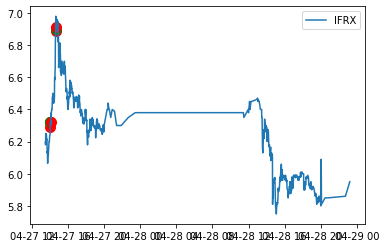

now=2020-04-27 10:20:52.356196
now=2020-04-27 10:34:00.078527
now=2020-04-27 10:53:53.139944
HTZ analysis for run 427 with profit 105.02


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3910.04,-3910.04,buy,2020-04-27 14:20:52.356196,4.09,"[3.935, 4.0083]",[4.13],956,"{'avg': 3.9949, 'rsi': 62.962972295227914, 'macd': [0.0071512354778136, 0.006228829556361504, 0.009822627429225683, 0.012127481860339628, 0.015789376564370627], 'vwap': 4.0841, 'supports': [3.8, 3.81, 3.85, 3.935, 4.0083], 'sell_macd': [0.003107565586979888, 0.0025887302003138046, 0.005007965870440501, 0.006568305796897711, 0.008997553716254991], 'slow macd': [0.026739346797705288, 0.02615762491566498, 0.02646023485159521, 0.026616358211518865, 0.02711726761509281], 'macd_signal': [0.007045217485159263, 0.006881939899399711, 0.007470077405364905, 0.00840155829635985, 0.009879121949962006], 'resistances': [4.13], 'sell_macd_signal': [0.00257404080550516, 0.002576978684466889, 0.0030631761216616113, 0.003764202056708831, 0.004810872388618063]}",4.39,3.99
1,86.04,3996.08,sell,2020-04-27 14:32:48.954012,4.18,None,None,956,"{'avg': 4.0103, 'rsi': [66.09341095129575, 70.97211067979887], 'vwap': 4.1799, 'reasons': 'bail', 'movement': 0.02200488997555009, 'sell_macd': [0.017545980555663476, 0.01714512673310331, 0.017051667563146466, 0.017796353046775515, 0.019963687799645413], 'sell_macd_signal': [0.015083894826748228, 0.015496141208019244, 0.01580724647904469, 0.016205067792590854, 0.016956791794001766]}",4.39,3.99
2,-2016.50,-2102.54,buy,2020-04-27 14:34:00.078527,4.18,"[3.935, 4.0083]","[4.21, 4.25]",503,"{'avg': 4.0134, 'rsi': 70.97302861138618, 'macd': [0.028686445002049865, 0.028616826346513413, 0.02983160573210153, 0.03322744022813673, 0.035517311240949034], 'vwap': 4.1737, 'supports': [3.8, 3.81, 3.85, 3.935, 4.0083], 'sell_macd': [0.01714512673310331, 0.017051667563146466, 0.017796353046775515, 0.019958492994449628, 0.021389270966735374], 'slow macd': [0.03115312674461901, 0.031379149813404617, 0.03185678375263734, 0.032803448510399846, 0.033623545197153604], 'macd_signal': [0.026002797557117704, 0.026525603314996846, 0.027186803798417782, 0.02839493108436157, 0.029819407115679063], 'resistances': [4.21, 4.25], 'sell_macd_signal': [0.015496141208019244, 0.01580724647904469, 0.016205067792590854, 0.01695575283296261, 0.017842456459717163]}",4.75,3.99
3,-1952.30,64.20,sell,2020-04-27 14:49:17.754405,4.28,None,None,15,"{'avg': 4.0357, 'rsi': [67.82447212110813, 70.45428209878483], 'vwap': 4.27, 'reasons': 'scale-out', 'movement': 0.021531100478468866, 'sell_macd': [0.024849869590056528, 0.023693085006632586, 0.024302173837645213, 0.024466370669113502, 0.025310337412217443], 'sell_macd_signal': [0.020791645133881896, 0.021371933108432033, 0.02195798125427467, 0.022459659137242436, 0.023029794792237438]}",4.75,3.99
4,-942.22,1010.08,sell,2020-04-27 14:49:17.801210,4.28,None,None,236,"{'avg': 4.0357, 'rsi': [67.82447212110813, 70.45428209878483], 'vwap': 4.27, 'reasons': 'scale-out', 'movement': 0.021531100478468866, 'sell_macd': [0.024849869590056528, 0.023693085006632586, 0.024302173837645213, 0.024466370669113502, 0.025310337412217443], 'sell_macd_signal': [0.020791645133881896, 0.021371933108432033, 0.02195798125427467, 0.022459659137242436, 0.023029794792237438]}",4.75,3.99
5,151.46,1093.68,sell,2020-04-27 14:51:05.948147,4.34,None,None,252,"{'avg': 4.0434, 'rsi': [77.25509850937318, 78.05187606170496], 'vwap': 4.35, 'reasons': 'rsi max', 'movement': 0.016355140186915747, 'sell_macd': [0.024302173837645213, 0.024466370669113502, 0.027128519230399384, 0.03067397889853929, 0.03355259709581038], 'sell_macd_signal': [0.02195798125427467, 0.022459659137242436, 0.023393431155873827, 0.024849540704406918, 0.02659015198268761]}",4.75,3.99
6,-973.42,-1124.88,buy,2020-04-27 14:53:53.139944,4.36,"[3.935, 4.0083]","[4.36, 4.44, 4.45, 4.45, 4.45, 4.53]",258,"{'avg': 4.0539, 'rsi': 73.45038799525396, 'macd': [0.04548973207919449, 0.0510437662096308, 0.05719870729519094, 0.05884831974347726, 0.06120116915745122], 'vwap': 4.36, 'supports': [3.8, 3.935, 4.0083], 'sell_m

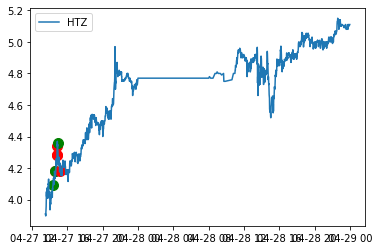

now=2020-04-27 10:23:05.409232
now=2020-04-27 10:26:06.262602
TNP analysis for run 427 with profit 101.98


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2863.04,-2863.04,buy,2020-04-27 14:23:05.409232,3.89,"[3.7341, 3.75, 3.77]",[3.9],736,"{'avg': 3.729, 'rsi': 74.83255740588677, 'macd': [0.018807294980737854, 0.021895579690593525, 0.026857676489590254, 0.030439288779521068, 0.03369622959038443], 'vwap': 3.89, 'supports': [3.47, 3.47, 3.5, 3.6, 3.61, 3.65, 3.7, 3.7, 3.7341, 3.74, 3.75, 3.77], 'sell_macd': [0.009631516431925835, 0.011734562095891299, 0.015039083884749171, 0.017418723150290916, 0.019566250848761513], 'slow macd': [0.0453857047045676, 0.04556682100531306, 0.04622035212246356, 0.04674769866067763, 0.04731804395847394], 'macd_signal': [0.018427322900169425, 0.019120974258254243, 0.020668314704521445, 0.02262250951952137, 0.02483725353369398], 'resistances': [3.9], 'sell_macd_signal': [0.00890030218201642, 0.009467154164791396, 0.010581540108782952, 0.011948976717084545, 0.013472431543419938]}",4.28,3.76
1,14.72,2877.76,sell,2020-04-27 14:24:58.833656,3.91,None,None,736,"{'avg': 3.7339, 'rsi': [74.83255740588677, 78.4888382038016], 'vwap': 3.9144, 'reasons': 'rsi max', 'movement': 0.0077120822622107465, 'sell_macd': [0.015039083884749171, 0.017418723150290916, 0.019566250848761513, 0.02098554190148194, 0.023377385034751175], 'sell_macd_signal': [0.010581540108782952, 0.011948976717084545, 0.013472431543419938, 0.014975053615032338, 0.016655519898976106]}",4.28,3.76
2,-2421.21,-2435.93,buy,2020-04-27 14:26:06.262602,3.91,"[3.7341, 3.75, 3.77]","[3.95, 3.98]",623,"{'avg': 3.7342, 'rsi': 77.78972668163892, 'macd': [0.026857676489590254, 0.030439288779521068, 0.03369622959038443, 0.035863961227495356, 0.03902826423403516], 'vwap': 3.9135, 'supports': [3.47, 3.47, 3.5, 3.6, 3.61, 3.65, 3.7, 3.7, 3.7341, 3.74, 3.75, 3.77], 'sell_macd': [0.015039083884749171, 0.017418723150290916, 0.019566250848761513, 0.02098554190148194, 0.023039722697089093], 'slow macd': [0.04622035212246356, 0.04674769866067763, 0.04731804395847394, 0.04776710127730466, 0.04847970123153056], 'macd_signal': [0.020668314704521445, 0.02262250951952137, 0.02483725353369398, 0.027042595072454257, 0.029439728904770437], 'resistances': [3.95, 3.98], 'sell_macd_signal': [0.010581540108782952, 0.011948976717084545, 0.013472431543419938, 0.014975053615032338, 0.01658798743144369]}",4.37,3.76
3,-1174.10,1247.11,sell,2020-04-27 14:41:12.634836,4.01,None,None,311,"{'avg': 3.7862, 'rsi': [66.72551383149022, 73.31180963596337], 'vwap': 3.9855, 'reasons': 'scale-out', 'movement': 0.02557544757033239, 'sell_macd': [0.011555952716049145, 0.013633062623250147, 0.015407004594793161, 0.017238556720738263, 0.02161069400432236], 'sell_macd_signal': [0.012134577873092682, 0.012434274823124175, 0.013028820777457973, 0.013870767966114032, 0.015418753173755698]}",4.37,3.76
4,101.98,1276.08,sell,2020-04-27 15:13:04.761511,4.09,None,None,312,"{'avg': 3.8459, 'rsi': [60.731921903426645, 63.61077526143267], 'vwap': 4.1, 'reasons': 'bail', 'movement': 0.02244389027431418, 'sell_macd': [0.01434763118677651, 0.015663486975627805, 0.015404887759464359, 0.015590331386357015, 0.01657132211658041], 'sell_macd_signal': [0.015388228796932987, 0.01544328043267195, 0.015435601898030431, 0.015466547795695748, 0.01568750265987268]}",4.37,3.76


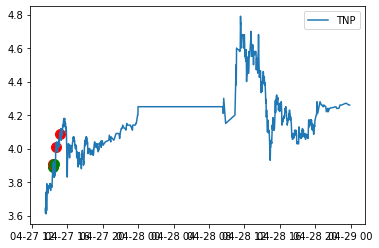

now=2020-04-27 10:06:56.403677
YTEN analysis for run 427 with profit 26.75


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-539.60,-539.60,buy,2020-04-27 14:06:56.403677,7.60,"[6.32, 6.33, 6.35]",[7.6261],71,"{'avg': 7.0945, 'rsi': 68.40560990677706, 'macd': [0.22958685689406533, 0.23479361496033935, 0.25981778592439664, 0.2719875177517981, 0.2808157974712522], 'vwap': 7.6407, 'supports': [5.16, 5.1649, 5.176, 5.2399, 6.32, 6.33, 6.35], 'sell_macd': [0.12778823422454977, 0.13135934545953276, 0.14781788219510972, 0.15580871754497405, 0.16157029421311453], 'slow macd': [0.2636691109013869, 0.26690613104827055, 0.2741931197862906, 0.2795616078338874, 0.28453347691272945], 'macd_signal': [0.25159973149652765, 0.24823850818929, 0.25055436373631135, 0.25484099453940867, 0.2600359551257774], 'resistances': [7.6261], 'sell_macd_signal': [0.14219567312026551, 0.14002840758811896, 0.14158630250951712, 0.1444307855166085, 0.14785868725590973]}",11.59,6.27
1,-264.85,274.75,sell,2020-04-27 14:07:20.647803,7.85,None,None,35,"{'avg': 7.102, 'rsi': [68.84393831262045, 72.39139598582908], 'vwap': 7.7748, 'reasons': 'scale-out', 'movement': 0.03157894736842108, 'sell_macd': [0.13135934545953276, 0.14781788219510972, 0.15580871754497405, 0.16286899551181655, 0.17742416021959162], 'sell_macd_signal': [0.14002840758811896, 0.14158630250951712, 0.1444307855166085, 0.14811842751565013, 0.15397957405643842]}",11.59,6.27
2,-119.77,145.08,sell,2020-04-27 14:07:44.407587,8.06,None,None,18,"{'avg': 7.1409, 'rsi': [68.84393831262045, 75.27238212593572], 'vwap': 8.0537, 'reasons': 'scale-out', 'movement': 0.026751592356688007, 'sell_macd': [0.13135934545953276, 0.14781788219510972, 0.15580871754497405, 0.16286899551181655, 0.18885273164816319], 'sell_macd_signal': [0.14002840758811896, 0.14158630250951712, 0.1444307855166085, 0.14811842751565013, 0.15626528834215275]}",11.59,6.27
3,26.75,146.52,sell,2020-04-27 14:18:42.633006,8.14,None,None,18,"{'avg': 7.3965, 'rsi': [63.29229437425422, 69.24845700199755], 'vwap': 8.2518, 'reasons': 'bail', 'movement': 0.027295285359801347, 'sell_macd': [0.20738197315304419, 0.19901055143814883, 0.18470800787539776, 0.17490462317876787, 0.1809941335037477], 'sell_macd_signal': [0.19886589025235568, 0.19889482248951432, 0.19605745956669102, 0.19182689228910638, 0.18966034053203465]}",11.59,6.27


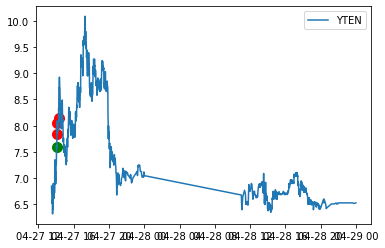

now=2020-04-27 09:55:39.172365
now=2020-04-27 09:55:40.902561
REAL analysis for run 427 with profit -44.28


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1537.80,-1537.80,buy,2020-04-27 13:55:39.172365,11.65,"[9.9, 10.1]",[11.72],132,"{'avg': 11.1251, 'rsi': 77.85377286490889, 'macd': [0.2816433222129291, 0.29349944194809297, 0.3146003968181166, 0.3211655278778984, 0.32424458465832195], 'vwap': 11.66, 'supports': [9.9, 10.05, 10.0775, 10.1, 10.11, 10.15, 10.16], 'sell_macd': [0.1731440332387404, 0.18003118584793576, 0.19292986079214103, 0.19631934956954566, 0.19744986875233472], 'slow macd': [0.13310022938525812, 0.1423947692582228, 0.15375708719931147, 0.1626853819748586, 0.17095937827659213], 'macd_signal': [0.23729228396226265, 0.24853371555942871, 0.2617470518111663, 0.27363074702451273, 0.28375351455127457], 'resistances': [11.72], 'sell_macd_signal': [0.14727128628126224, 0.15382326619459694, 0.16164458511410576, 0.16857953800519374, 0.17435360415462192]}",13.41,11.08
1,-1910.60,-372.80,buy,2020-04-27 13:55:40.902561,11.65,"[9.9, 10.1]",[11.72],32,"{'avg': 11.1251, 'rsi': 77.85377286490889, 'macd': [0.2816433222129291, 0.29349944194809297, 0.3146003968181166, 0.3211655278778984, 0.32424458465832195], 'vwap': 11.66, 'supports': [9.9, 10.05, 10.0775, 10.1, 10.11, 10.15, 10.16], 'sell_macd': [0.1731440332387404, 0.18003118584793576, 0.19292986079214103, 0.19631934956954566, 0.19744986875233472], 'slow macd': [0.13310022938525812, 0.1423947692582228, 0.15375708719931147, 0.1626853819748586, 0.17095937827659213], 'macd_signal': [0.23729228396226265, 0.24853371555942871, 0.2617470518111663, 0.27363074702451273, 0.28375351455127457], 'resistances': [11.72], 'sell_macd_signal': [0.14727128628126224, 0.15382326619459694, 0.16164458511410576, 0.16857953800519374, 0.17435360415462192]}",13.41,11.08
2,-44.28,1866.32,sell,2020-04-27 14:33:25.906838,11.38,None,None,164,"{'avg': 11.3019, 'rsi': [46.90473390002909, 46.68617405722382], 'vwap': 11.3867, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.022600858369098795, 'sell_macd': [0.006928552053960146, 0.006189348791634686, 0.005532965096424647, 0.0013132769560471047, -0.00216327584107745], 'sell_macd_signal': [0.02262101530001366, 0.019334681998337867, 0.016574338617955223, 0.013522126285573598, 0.01038504586024339]}",13.41,11.08


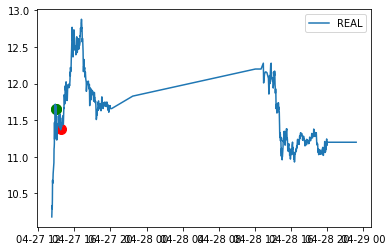

now=2020-04-27 09:48:46.899889
MGM analysis for run 427 with profit -1.95


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2843.10,-2843.10,buy,2020-04-27 13:48:46.899889,14.58,"[14.13, 14.2, 14.21, 14.21]","[14.89, 14.9, 15.25, 15.3]",195,"{'avg': 14.3518, 'rsi': 77.95753958343342, 'macd': [0.11925351058615341, 0.11896899617692469, 0.1177891743899, 0.11931165960644918, 0.12014196386891385], 'vwap': 14.5761, 'supports': [14.13, 14.18, 14.2, 14.2, 14.21, 14.21, 14.21, 14.22, 14.24, 14.28, 14.3], 'sell_macd': [0.07444391506635561, 0.0738217777132526, 0.07263801123403901, 0.07323977746797539, 0.07340687092990095], 'slow macd': [0.054095048864700956, 0.056942636791356804, 0.05955140499290401, 0.06261600715675542, 0.06553531365431375], 'macd_signal': [0.09997975113744102, 0.10377760014533775, 0.10657991499425021, 0.10912626391669, 0.11132940390713478], 'resistances': [14.89, 14.9, 15.25], 'sell_macd_signal': [0.06345630683363064, 0.06552940100955504, 0.06695112305445183, 0.06820885393715655, 0.06924845733570542]}",16.05,14.09
1,-672.17,2170.93,sell,2020-04-27 13:48:48.057449,14.57,None,None,149,"{'avg': 14.3559, 'rsi': [77.31523260132806, 78.91285351254102], 'vwap': 14.5996, 'reasons': 'rsi max', 'movement': 0.001371742112482824, 'sell_macd': [0.07444391506635561, 0.0738217777132526, 0.07263801123403901, 0.07323977746797539, 0.07444583196886256], 'sell_macd_signal': [0.06345630683363064, 0.06552940100955504, 0.06695112305445183, 0.06820885393715655, 0.06945624954349774]}",16.05,14.09
2,-1.95,670.22,sell,2020-04-27 13:48:48.122509,14.57,None,None,46,"{'avg': 14.3559, 'rsi': [77.31523260132806, 78.91285351254102], 'vwap': 14.5996, 'reasons': 'rsi max', 'movement': 0.001371742112482824, 'sell_macd': [0.07444391506635561, 0.0738217777132526, 0.07263801123403901, 0.07323977746797539, 0.07444583196886256], 'sell_macd_signal': [0.06345630683363064, 0.06552940100955504, 0.06695112305445183, 0.06820885393715655, 0.06945624954349774]}",16.05,14.09


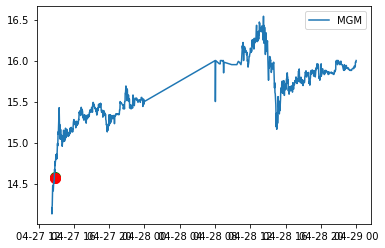

now=2020-04-27 10:48:16.155909
RESN analysis for run 427 with profit 103.81


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4056.38,-4056.38,buy,2020-04-27 14:48:16.155909,2.54,"[2.47, 2.49, 2.51]",[2.55],1597,"{'avg': 2.479, 'rsi': 62.11564381576326, 'macd': [0.0032561151682157785, 0.004099335253938463, 0.004266538053248503, 0.004795639527884532, 0.00675096815299403], 'vwap': 2.54, 'supports': [2.25, 2.28, 2.28, 2.3779, 2.39, 2.42, 2.42, 2.42, 2.47, 2.49, 2.51], 'sell_macd': [0.0018918667963143676, 0.0024515696993421265, 0.0025649541731382897, 0.002910903708913004, 0.004181631870439961], 'slow macd': [0.014503328892102818, 0.014386624532921388, 0.014166679219603573, 0.014031229046543636, 0.01420404161575739], 'macd_signal': [5.144103310510096e-05, 0.0008610198772717733, 0.0015421235124671194, 0.002192826715550602, 0.003104455003039288], 'resistances': [2.55, 2.55], 'sell_macd_signal': [-0.0003777638881021149, 0.00018810282938673344, 0.0006634730981370446, 0.0011129592202922364, 0.0017266937503217813]}",2.72,2.48
1,-1981.58,2074.80,sell,2020-04-27 15:18:30.650800,2.60,None,None,798,"{'avg': 2.493, 'rsi': [76.92664043165011, 76.92664043165011], 'vwap': 2.6, 'reasons': 'scale-out', 'movement': 0.02362204724409451, 'sell_macd': [0.008187926934914547, 0.008533290148742267, 0.009216257716027076, 0.010148229096819783, 0.010742645379297144], 'sell_macd_signal': [0.0062201145122484265, 0.006682749639547195, 0.007189451254843171, 0.007781206823238494, 0.008373494534450224]}",2.72,2.48
2,103.81,2085.39,sell,2020-04-27 15:18:52.508994,2.61,None,None,799,"{'avg': 2.4931, 'rsi': [76.92664043165011, 79.36013446516719], 'vwap': 2.61, 'reasons': 'rsi max', 'movement': 0.0038076923076923153, 'sell_macd': [0.008187926934914547, 0.008533290148742267, 0.009216257716027076, 0.010148229096819783, 0.011256931093582612], 'sell_macd_signal': [0.0062201145122484265, 0.006682749639547195, 0.007189451254843171, 0.007781206823238494, 0.008476351677307318]}",2.72,2.48


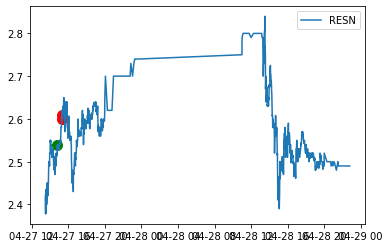

now=2020-04-27 10:13:42.387103
FRO analysis for run 427 with profit 149.73


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4951.94,-4951.94,buy,2020-04-27 14:13:42.387103,11.41,[11.24],[11.51],434,"{'avg': 11.2755, 'rsi': 69.29445731620511, 'macd': [0.039828530201212686, 0.039858553526071816, 0.04069622361220304, 0.042013529535955385, 0.04655542415386904], 'vwap': 11.4085, 'supports': [11.0699, 11.08, 11.18, 11.21, 11.22, 11.24, 11.25, 11.25, 11.25], 'sell_macd': [0.019536956647851156, 0.01979298165290544, 0.02056140397303885, 0.0216256109241435, 0.02477141360131263], 'slow macd': [0.09307519567458122, 0.09230717869288085, 0.0917072443507525, 0.09123412244006168, 0.09145259904691372], 'macd_signal': [0.04643804617112303, 0.04512214764211279, 0.044236962836130836, 0.04379227617609575, 0.04434490577165041], 'resistances': [11.51], 'sell_macd_signal': [0.02285072613673651, 0.022239177239970296, 0.021903622586584008, 0.021848020254095907, 0.022432698923539253]}",12.09,11.21
1,-2426.06,2525.88,sell,2020-04-27 15:01:40.024222,11.64,None,None,217,"{'avg': 11.3461, 'rsi': [62.15909080355979, 65.08208027577986], 'vwap': 11.6447, 'reasons': 'scale-out', 'movement': 0.020595968448729136, 'sell_macd': [0.012900630610547026, 0.010158492432568167, 0.010227495249303331, 0.012226361142225528, 0.01492383636862904], 'sell_macd_signal': [0.017795725982647344, 0.016268279272631508, 0.015060122467965873, 0.014493370202817804, 0.014579463435980052]}",12.09,11.21
2,149.73,2575.79,sell,2020-04-27 15:29:04.313342,11.87,None,None,217,"{'avg': 11.4164, 'rsi': [56.60323527421829, 65.11479341027884], 'vwap': 11.88, 'reasons': 'bail', 'movement': 0.020618556701030945, 'sell_macd': [0.025348489097218874, 0.021685735426469677, 0.021666891846322756, 0.0203318592923587, 0.023702848740018823], 'sell_macd_signal': [0.02990585191174038, 0.02826182861468624, 0.026942841261013543, 0.025620644867282574, 0.025237085641829825]}",12.09,11.21


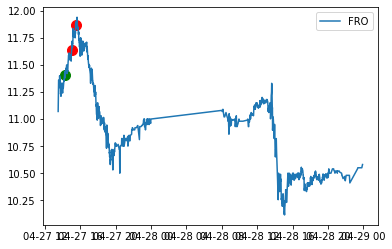

now=2020-04-27 10:36:33.144784
VXRT analysis for run 427 with profit 23.52


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1493.52,-1493.52,buy,2020-04-27 14:36:33.144784,3.81,[3.59],[3.9355],392,"{'avg': 3.711, 'rsi': 60.82967503305704, 'macd': [-0.024923276815196793, -0.015655384862697908, -0.009013527807461674, -0.0017127733874624518, 0.006738960399004235], 'vwap': 3.806, 'supports': [3.09, 3.22, 3.23, 3.59, 3.6064, 3.7901], 'sell_macd': [-0.017005959872579357, -0.01072397718258511, -0.00620913382437438, -0.0013117346644131445, 0.004287689806523165], 'slow macd': [0.0496071420616615, 0.049221672318020104, 0.04862836861174591, 0.04840457600775405, 0.048665045785516], 'macd_signal': [-0.029749841871145287, -0.02693095046945581, -0.023347465937056982, -0.019020527427138077, -0.013868629861909613], 'resistances': [3.9355, 4.01], 'sell_macd_signal': [-0.02166092367289972, -0.019473534374836798, -0.016820654264744314, -0.01371887034467808, -0.010117558314437832]}",4.55,3.57
1,-727.16,766.36,sell,2020-04-27 15:14:25.756807,3.91,None,None,196,"{'avg': 3.7238, 'rsi': [64.42569589685979, 67.09748212562432], 'vwap': 3.8824, 'reasons': 'scale-out', 'movement': 0.020997375328084007, 'sell_macd': [0.004992379946154646, 0.005103949488426629, 0.00564408225528279, 0.008589067758608682, 0.011811276361737733], 'sell_macd_signal': [0.0047507959320323015, 0.004821426643311167, 0.004985957765705491, 0.005706579764286129, 0.006927519083776449]}",4.55,3.57
2,23.52,750.68,sell,2020-04-27 15:32:05.959482,3.83,None,None,196,"{'avg': 3.7411, 'rsi': [45.483245550973834, 44.79680384953381], 'vwap': 3.831, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.020460358056266004, 'sell_macd': [0.007749256700887219, 0.0068901127324108025, 0.0046974016825278575, 0.002023894349080013, -0.0003453827204777937], 'sell_macd_signal': [0.01427994586182986, 0.012801979235946049, 0.01118106372526241, 0.009349629850025932, 0.0074106273359251865]}",4.55,3.57


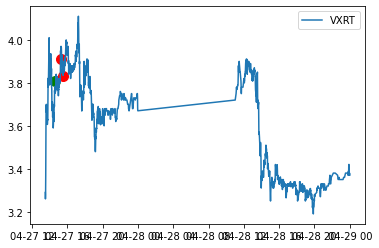

now=2020-04-27 10:32:30.347442
JMIA analysis for run 427 with profit -4.55


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2106.65,-2106.65,buy,2020-04-27 14:32:30.347442,4.63,"[4.45, 4.46, 4.51]",[4.6855],455,"{'avg': 4.5405, 'rsi': 61.39447075909232, 'macd': [-0.0038573940741279955, 0.0006490999703148148, 0.007363314962737455, 0.011702220555516618, 0.015805896213044512], 'vwap': 4.63, 'supports': [4.2, 4.21, 4.28, 4.29, 4.32, 4.3299, 4.33, 4.45, 4.46, 4.51], 'sell_macd': [-0.0036417589491684055, -0.0005830422718853256, 0.0038858673762813822, 0.006772214279057387, 0.009478819472400701], 'slow macd': [0.029070635663056343, 0.029083307339680786, 0.02968819510399623, 0.030029296249647786, 0.030463025378454134], 'macd_signal': [-0.006000174686276562, -0.004670319754958287, -0.0022635928114191385, 0.0005295698619680132, 0.003584835132183313], 'resistances': [4.6855], 'sell_macd_signal': [-0.005731075640723967, -0.004701468966956239, -0.0029840016983087147, -0.0010327585028354943, 0.0010695570922117446]}",5.26,4.42
1,-4.55,2102.10,sell,2020-04-27 15:12:18.713450,4.62,None,None,455,"{'avg': 4.5798, 'rsi': [44.999531905297964, 44.84484073579256], 'vwap': 4.6292, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.00017278617710581251, 'sell_macd': [0.003379615798092317, 0.003788826400476175, 0.00181433042310708, 8.596563005180968e-05, -0.001303487009082005], 'sell_macd_signal': [0.004421367502129555, 0.004294859281798879, 0.003798753510060519, 0.003056195934058777, 0.0021842593454306208]}",5.26,4.42


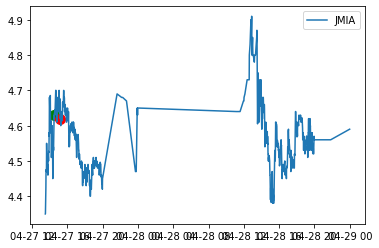

now=2020-04-27 09:49:06.184959
PENN analysis for run 427 with profit 13.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1744.55,-1744.55,buy,2020-04-27 13:49:06.184959,15.17,"[14.4, 14.55, 14.56, 14.7]","[15.35, 15.365, 15.45]",115,"{'avg': 14.7922, 'rsi': 75.97061217733709, 'macd': [0.22644899424686926, 0.21795976286088603, 0.2160042708876979, 0.22238097351967134, 0.22484270950176288], 'vwap': 15.1855, 'supports': [14.05, 14.1, 14.21, 14.21, 14.4, 14.4, 14.54, 14.55, 14.56, 14.7], 'sell_macd': [0.13892364511317012, 0.1327046999541288, 0.13081065567495287, 0.13438918408501088, 0.13543233370213237], 'slow macd': [0.1147382447987777, 0.11839849090766208, 0.12301609679847125, 0.1291468631989332, 0.134580812033267], 'macd_signal': [0.20421387772936012, 0.2069630547556653, 0.2087712979820718, 0.21149323308959173, 0.21416312837202595], 'resistances': [15.365], 'sell_macd_signal': [0.12727820676181428, 0.1283635054002772, 0.12885293545521231, 0.12996018518117203, 0.1310546148853641]}",17.68,14.36
1,13.80,1758.35,sell,2020-04-27 13:50:07.661788,15.29,None,None,115,"{'avg': 14.8223, 'rsi': [77.2227716030478, 78.43306333539296], 'vwap': 15.2562, 'reasons': 'rsi max', 'movement': 0.007910349373763956, 'sell_macd': [0.1327046999541288, 0.13081065567495287, 0.13438918408501088, 0.1380297362995364, 0.14167133885241867], 'sell_macd_signal': [0.1283635054002772, 0.12885293545521231, 0.12996018518117203, 0.1315740954048449, 0.13359354409435967]}",17.68,14.36


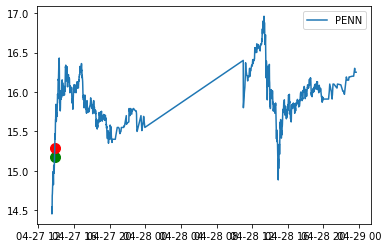

now=2020-04-27 10:29:43.359819
AVDL analysis for run 427 with profit -103.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2149.74,-2149.74,buy,2020-04-27 14:29:43.359819,13.27,"[12.3179, 12.7191]","[13.5, 13.5, 14.0, 14.43, 15.01]",162,"{'avg': 12.9469, 'rsi': 71.64668827777966, 'macd': [0.0957787402724275, 0.10200111255158717, 0.11050808670133705, 0.12149778910696796, 0.1406811993779673], 'vwap': 13.2797, 'supports': [12.3179, 12.5593, 12.7191, 12.8, 12.87, 13.0], 'sell_macd': [0.0479415940924266, 0.052482625074798506, 0.05846157616398706, 0.0659976214781075, 0.0787997655997863], 'slow macd': [0.30273845461773874, 0.2997865905540902, 0.29755252994926273, 0.29614078122015286, 0.2967657324594324], 'macd_signal': [0.11788892738142251, 0.11471136441545544, 0.11387070887263176, 0.115396124919499, 0.12045313981119266], 'resistances': [13.9], 'sell_macd_signal': [0.06013020687051451, 0.05860069051137131, 0.05857286764189446, 0.06005781840913707, 0.06380620784726691]}",15.05,12.69
1,-103.68,2046.06,sell,2020-04-27 14:37:38.668726,12.63,None,None,162,"{'avg': 12.9665, 'rsi': [50.64123588273728, 39.75478800033635], 'vwap': 12.7135, 'reasons': 'stopped', 'movement': -0.04747550866616421, 'sell_macd': [0.07137820779997739, 0.06813614574618931, 0.06426783575952122, 0.05307866127952643, 0.026527633616160173], 'sell_macd_signal': [0.07585517528101574, 0.07431136937405045, 0.0723026626511446, 0.06845786237682097, 0.060071816624688815]}",15.05,12.69


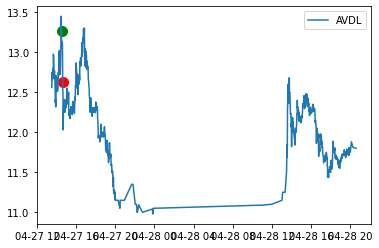

In [26]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

SDC analysis for run 428
operation buy price 6.71 qty 53


TypeError: object of type 'Timestamp' has no len()

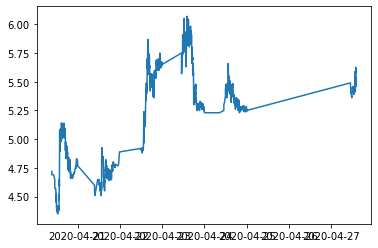

In [14]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])



In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))